# CHE1147 Data Mining in Engineering
### Assignment 5 Jialin Shang 1005086256
## 1 Supervised Learning 
### 1.1 Import the monthly and annual data and join
In Assignment 3, you created five different feature families that capture annual and monthly
aggregations. Here, you will model the retail problem with two approaches: using annual
and monthly features. Therefore, you need to create the joined tables based on the following
logic: In both the annual and monthly features approach, you need to join at the end with table
4, the clients responses. This is simply a table that contains the binary response of the
client to our marketing effort as described above and that is the output or label or target
that makes this a supervised learning problem.

In [1]:
# Import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, roc_curve, auc, f1_score

In [2]:
# Import kaggle dataset
kaggle = pd.read_csv('Retail_Data_Response.csv')

# Import annual feature & annual pivot dataset
annual_features = pd.read_excel('annual_features.xlsx')
annual_pivot = pd.read_excel('annual_day_of_week_counts_pivot.xlsx')
annual_features_outputs = pd.merge(annual_features, annual_pivot, on = 'customer_id').merge(kaggle, on = 'customer_id')
annual_features_outputs.head()

,customer_id,ann_txn_amt_avg-2011,ann_txn_amt_avg-2012,ann_txn_amt_avg-2013,ann_txn_amt_avg-2014,ann_txn_amt_avg-2015,ann_txn_amt_cnt-2011,ann_txn_amt_cnt-2012,ann_txn_amt_cnt-2013,ann_txn_amt_cnt-2014,...,cnt-2014-Tuesday,cnt-2014-Wednesday,cnt-2015-Friday,cnt-2015-Monday,cnt-2015-Saturday,cnt-2015-Sunday,cnt-2015-Thursday,cnt-2015-Tuesday,cnt-2015-Wednesday,response
0,CS1112,70.666667,67.400000,70.666667,70.666667,39.000000,3,5,3,3,...,1,1,0,0,0,0,0,0,1,0
1,CS1113,81.333333,74.800000,85.200000,56.500000,73.333333,3,5,5,4,...,3,0,0,2,0,0,0,0,1,0
2,CS1114,85.200000,75.000000,70.400000,70.833333,79.000000,5,2,5,6,...,1,1,0,0,0,0,1,0,0,1
3,CS1115,87.000000,67.571429,79.571429,78.250000,55.000000,3,7,7,4,...,0,2,0,0,0,0,1,0,0,1
4,CS1116,58.750000,76.666667,59.000000,66.600000,0.000000,4,3,1,5,...,0,0,0,0,0,0,0,0,0,1


In [3]:
# Import month features
mth_rolling_features = pd.read_excel('mth_rolling_features.xlsx')
mth_rolling_features = mth_rolling_features.drop('Unnamed: 0', axis = 1)
mth_rolling_features = mth_rolling_features.fillna(0)

mth_day_counts = pd.read_excel('mth_day_counts.xlsx')
mth_day_counts = mth_day_counts.drop('Unnamed: 0', axis = 1)

day_since_last_txn = pd.read_excel('days_since_last_txn.xlsx')
day_since_last_txn = day_since_last_txn.drop('Unnamed: 0', axis = 1)

mth_features_outputs = pd.merge(mth_rolling_features, mth_day_counts, on = ['CLNT_NO', 'ME_DT']).merge(day_since_last_txn, on = ['CLNT_NO', 'ME_DT']).merge(kaggle.rename(columns={'customer_id': 'CLNT_NO'}), on = 'CLNT_NO')
mth_features_outputs.head() 

,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,txn_cnt_max_3M,...,txn_cnt_max_12M,cnt-Friday,cnt-Monday,cnt-Saturday,cnt-Sunday,cnt-Thursday,cnt-Tuesday,cnt-Wednesday,days_since_last_txn,response
0,CS1112,2011-05-31,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0,0,0,0,0,0,0,50,0
1,CS1112,2011-06-30,56,1,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0,0,0,0,0,0,1,15,0
2,CS1112,2011-07-31,0,0,56.0,18.666667,56.0,1.0,0.333333,1.0,...,0.0,0,0,0,0,0,0,0,46,0
3,CS1112,2011-08-31,96,1,152.0,50.666667,96.0,2.0,0.666667,1.0,...,0.0,1,0,0,0,0,0,0,12,0
4,CS1112,2011-09-30,0,0,96.0,32.000000,96.0,1.0,0.333333,1.0,...,0.0,0,0,0,0,0,0,0,42,0


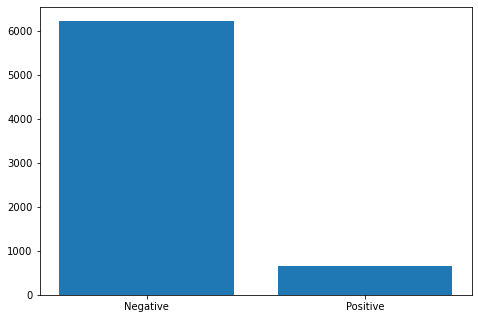

In [4]:
# Determine whether the dataset is imbalanced
label = list(np.array(kaggle["response"]))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Negative', 'Positive']
students = [label.count(0), label.count(1)]
ax.bar(langs,students)
plt.show()

According to the above graph, we can clearly see that this dataset is imbalanced because the number of negative values are many more than the number of positive values. 

## 1.2 Steps for Each Method
1. Separate the inputs X and the output y in two data frames.

In [5]:
annual_X = annual_features_outputs.drop(['customer_id', 'response'], axis = 1)
annual_y = annual_features_outputs['response']

2. Split the data in train and test set. Use a test size value of 2/3 and set the random state
equal to 1147 for consistency (i.e. the course code value). Use the following names for
consistency.

In [6]:
annual_X_train, annual_X_test, annual_y_train, annual_y_test = train_test_split(annual_X, annual_y, test_size = 2/3, random_state = 1147)

3. Pre-process (if necessary for the method).

In [7]:
scaler = StandardScaler()
annual_X_train_scaled = scaler.fit_transform(annual_X_train)
annual_X_test_scaled = scaler.transform(annual_X_test)

## Logistic Regression with L1 regularization - Annual

4. Fit the training dataset and optimize the hyperparameters of the method.

In [8]:
def lr_best(X_train, y_train, X_test, y_test):
    # Define the range for optimal c
    lr_C = [0.005, 0.025, 0.01, 0.05, 0.25, 0.1, 0.5, 1, 5, 10]
    estimator_c = []
    acc_train = [] 
    acc_test = [] 
    precisions = []
    recalls = [] 
    f1_train = [] 
    f1_test = [] 
    auc_train = [] 
    auc_test = []
    # Construct a for loop
    for x in range(len(lr_C)):
        # Define and fit
        c = lr_C[x]
        estimator_c.append(LogisticRegression(penalty = 'l1', C = c, solver = 'liblinear', class_weight = 'balanced', random_state = 1147))
        estimator_c[x].fit(X_train, y_train)

        # Score train and test set
        train_score = estimator_c[x].predict_proba(X_train)[:, 1] 
        test_score  = estimator_c[x].predict_proba(X_test)[:, 1]  

        # Predict the class of training and test set
        y_train_predicted = estimator_c[x].predict(X_train)
        y_test_predicted = estimator_c[x].predict(X_test)
  
        # Calculate training and test accuracy at every iteration and append
        acc_train.append(100 * accuracy_score(y_train, y_train_predicted, normalize = True))
        acc_test.append(100 * accuracy_score(y_test, y_test_predicted, normalize = True))
     
        # Calculate training and test F1 score at every iteration and append
        f1_train.append(100 * f1_score(y_train, y_train_predicted))
        f1_test.append(100 * f1_score(y_test, y_test_predicted))
     
        # Calculate precision and recall for test set
        precisions.append(precision_score(y_test, y_test_predicted))
        recalls.append(recall_score(y_test, y_test_predicted))
    
        # ROC Calc for training and test set
        fpr_train, tpr_train, _ = roc_curve(y_train, train_score)
        fpr_test, tpr_test, _ = roc_curve(y_test, test_score)
    
        # Calculate the AUCs
        auc_train.append(auc(fpr_train, tpr_train))
        auc_test.append(auc(fpr_test, tpr_test))
    
        # Generate a summary table for all metrics
        performance_dictionary = {'ACCURACY_TRAIN': acc_train, 'ACCURACY_TEST': acc_test, 
                                  'F1_TRAIN': f1_train, 'F1_TEST': f1_test, 
                                  'PRECISION': precisions, 'RECALL': recalls, 
                                  'AUC_TRAIN': auc_train, 'AUC_TEST': auc_test}
        lr_performance = pd.DataFrame(performance_dictionary)

    lr_performance.insert(0, 'C', value = lr_C)
    return lr_performance

In [9]:
# Show the data frame
import warnings 
warnings.filterwarnings("ignore")
annual_lr_performance = lr_best(annual_X_train_scaled, annual_y_train, annual_X_test_scaled, annual_y_test)
annual_lr_performance

,C,ACCURACY_TRAIN,ACCURACY_TEST,F1_TRAIN,F1_TEST,PRECISION,RECALL,AUC_TRAIN,AUC_TEST
0,0.005,58.151700,59.281046,25.696594,29.284904,0.176551,0.858093,0.780110,0.761302
1,0.025,70.270270,69.586057,30.971660,31.769306,0.203762,0.720621,0.799124,0.772499
2,0.010,62.685266,63.769063,27.457627,30.563674,0.188272,0.811530,0.783154,0.765955
3,0.050,71.534438,70.283224,31.045407,31.180626,0.201829,0.685144,0.808258,0.765016
4,0.250,72.929381,71.525054,32.573290,30.293333,0.199438,0.629712,0.821348,0.749198
5,0.100,71.970357,71.089325,31.376734,31.136482,0.203252,0.665188,0.812457,0.757648
6,0.500,72.842197,71.677560,32.356135,30.182599,0.199150,0.623060,0.824692,0.742992
7,1.000,72.537053,71.677560,32.112069,29.729730,0.196569,0.609756,0.826030,0.737881
8,5.000,72.406277,71.328976,32.154341,29.474812,0.194346,0.609756,0.826735,0.732949
9,10.000,72.406277,71.350763,32.154341,29.339065,0.193617,0.605322,0.826869,0.732205


Choose the optimal c = 0.05.

Both F1_TEST score and AUC_TEST scores are quite high for c = 0.05. The reason for not choosing c = 0.025 & c = 0.01 is because the ACCURY_TEST scores are not above 70. So c = 0.05 is more suitable. 

5. Plot coefficient values or feature importance.

In [10]:
def logistic(X_train, X_test, y_train, y_test, X, best_param):
    # Define the best logistic model 
    best_lr_model = LogisticRegression(penalty = 'l1',solver = 'liblinear', C = best_param, class_weight = 'balanced', random_state = 1147)
    best_lr_model.fit(X_train, y_train)
    coe = best_lr_model.coef_
    
    index = np.argsort(abs(coe[0]))[::-1]
    name = [X.columns[x] for x in index]
    print(f'The indices for top 2 features are: {index[0]}:{name[0]}, {index[1]}:{name[1]} ')
 
    # Plot coefficient values 
    plt.figure(figsize = (16,7)) 
    plt.bar(range(X.shape[1]), coe[0])
    plt.title("Coefficient values")
    plt.xticks(range(X.shape[1]), X.columns, rotation = 90,size = 7)
    plt.show()
 
    # Prediction and predicted probability 
    y_test_pred = best_lr_model.predict(X_test) 
    y_test_prob = best_lr_model.predict_proba(X_test) 
   
    # Scores for ROC curves 
    train_score = best_lr_model.predict_proba(X_train)[:, 1]
    test_score = best_lr_model.predict_proba(X_test)[:, 1] 
        
    return best_lr_model, y_test_pred, y_test_prob, train_score, test_score

The indices for top 2 features are: 32:ann_txn_amt_sum-2013, 8:ann_txn_amt_cnt-2014 


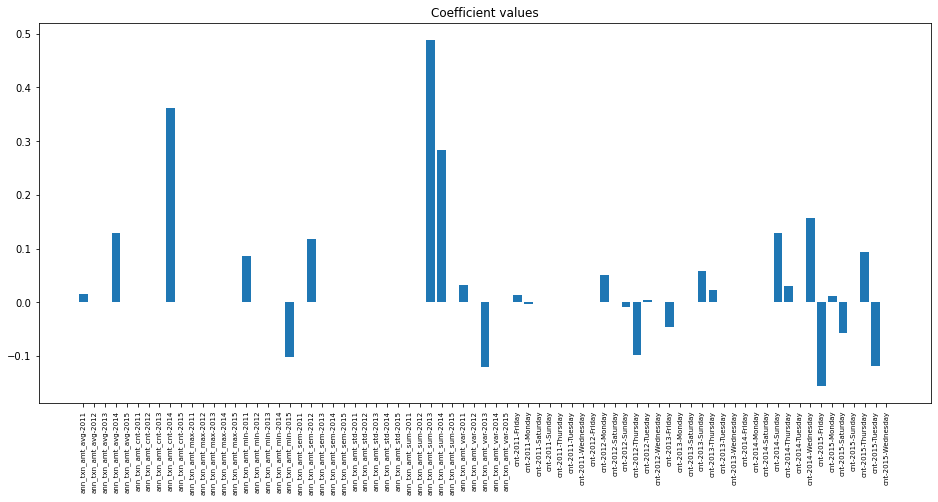

In [11]:
best_lr_model, y_test_pred, y_test_prob, scores_train, scores_test = logistic(annual_X_train_scaled, annual_X_test_scaled, annual_y_train, annual_y_test, annual_X_train, 0.05)

6. Plot probability distribution for test set.

Text(3.674999999999997, 0.5, 'Counts Of Clients')

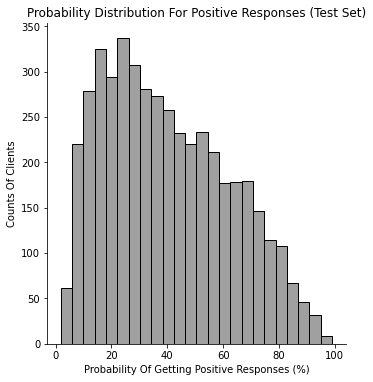

In [12]:
sns.displot(data = y_test_prob[:, 1], x = 100 * y_test_prob[:, 1], color = 'grey')
plt.title('Probability Distribution For Positive Responses (Test Set)')
plt.xlabel('Probability Of Getting Positive Responses (%)')
plt.ylabel('Counts Of Clients')

7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

In [13]:
# Define the confusion matrix function
def confusion_matrix_test(y_test, y_test_predicted):
 
    matrix = confusion_matrix(y_test, y_test_predicted)
 
    precision = matrix[1,1] / matrix.sum(axis = 0)[1]
    recall = matrix[1,1] / matrix.sum(axis = 1)[1]
 
    classNames = ['Negative','Positive']
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation = 45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    thresh = matrix.max() / 2.
    for a in range(2):
        for b in range(2):
            plt.text(b,a, str(s[a][b]) + " = " + str(matrix[a][b]), fontsize = 10,
                     horizontalalignment="center",
                     color = "white" if matrix[a, b] > thresh else "black")
    plt.imshow(matrix, interpolation='nearest', cmap = plt.cm.Blues)
    
    print('Precision:', precision)
    print('Recall', recall)

Precision: 0.20182887001959504
Recall 0.6851441241685144


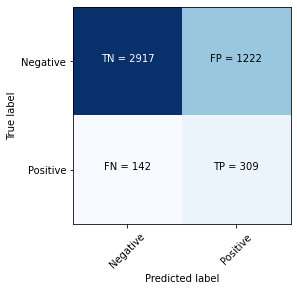

In [14]:
# For Test Set
confusion_matrix_test(annual_y_test.values, y_test_pred)

In [15]:
def roc(y_train, train_score, y_test, test_score, model_name):
 
    fpr_train, tpr_train, _ = roc_curve(y_train, train_score)
    fpr_test, tpr_test, _ = roc_curve(y_test, test_score)
    
    train_auc = auc(fpr_train, tpr_train)
    test_auc  = auc(fpr_test, tpr_test)
 
    # Plotting
    plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(train_auc))
    plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(test_auc))
    plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5')
    plt.xlim([0,1.0])
    plt.ylim([0,1.0])
    plt.title('{} ROC curves'.format(model_name))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

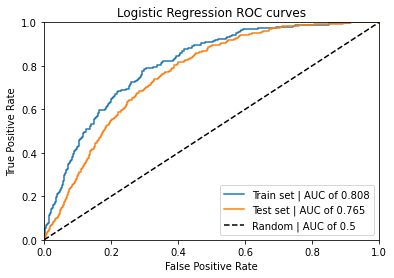

In [16]:
roc(annual_y_train, scores_train, annual_y_test, scores_test, 'Logistic Regression')

8. Plot decision boundary for top 2 features.

In [17]:
def decision_boundary(best_model, feature1, feature2, X_train_scaled, X, y_train):
    
    min_v1, min_v2 = np.floor(X_train_scaled.min(axis=0)[[feature1, feature2]])
    max_v1, max_v2 = np.ceil(X_train_scaled.max(axis=0)[[feature1, feature2]])

    step1, step2 = (max_v1 - min_v1)/10, (max_v2 - min_v2) / 10
    xx, yy = np.mgrid[min_v1:max_v1:step1, min_v2:max_v2:step2]
    grid = np.c_[xx.ravel(), yy.ravel()]
    median_inputs = np.ones((100, X.shape[1])) * np.median(X_train_scaled, axis = 0)
    median_inputs[:,feature1] = grid[:,0]
    median_inputs[:,feature2] = grid[:,1]
 
    probs = best_model.predict_proba(median_inputs)[:, 1].reshape(xx.shape)
 
    f, ax = plt.subplots(figsize = (8, 6))
    contour = ax.contourf(xx, yy, probs, 25, cmap = "RdBu", vmin = 0, vmax = 1)
    ax_c = f.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])
    
    ax.scatter(X_train_scaled[50:,feature1], X_train_scaled[50:,feature2], c = y_train[50:], s = 50,
               cmap = "RdBu", vmin = -.2, vmax = 1.2, edgecolor = "white", linewidth = 1)
 
    ax.set(aspect = "auto", xlim = (min_v1, max_v1), ylim = (min_v2, max_v2),
           xlabel = f"{X.columns[feature1]}", ylabel = f"{X.columns[feature2]}")

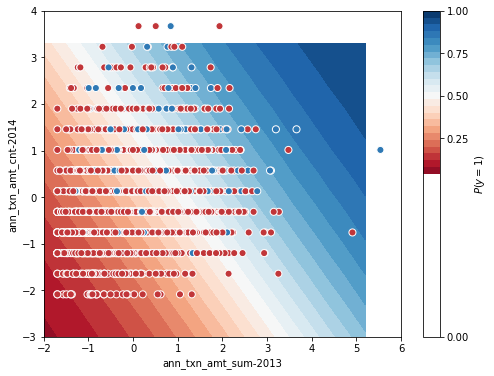

In [19]:
decision_boundary(best_lr_model, 32, 8, annual_X_train_scaled, annual_X_train, annual_y_train)

## Decision Tree - Annual

4. Fit the training dataset and optimize the hyperparameters of the method.

In [23]:
def dt_best(X_train, y_train, X_test, y_test): 

    max_depth_range = range(2, 11) 
    estimator_max_depth, accuracy_train, accuracy_test, precisions, recalls, f1_train, f1_test, auc_train, auc_test = [],[],[],[],[],[],[],[],[] 
 
    for m in max_depth_range: 

        estimator_max_depth.append(DecisionTreeClassifier(max_depth = m, random_state = 1147, class_weight = 'balanced')) 
        estimator_max_depth[m - 2].fit(X_train, y_train) 
 
        scores_train = estimator_max_depth[m - 2].predict_proba(X_train)[:,1] 
        scores_test  = estimator_max_depth[m - 2].predict_proba(X_test)[:,1]  

        y_train_predicted = estimator_max_depth[m - 2].predict(X_train) 
        y_test_predicted = estimator_max_depth[m - 2].predict(X_test) 

        accuracy_train.append(100 * accuracy_score(y_train, y_train_predicted, normalize = True)) 
        accuracy_test.append(100 * accuracy_score(y_test, y_test_predicted, normalize = True)) 

        f1_train.append(100 * f1_score(y_train, y_train_predicted)) 
        f1_test.append(100 * f1_score(y_test, y_test_predicted)) 

        precisions.append(precision_score(y_test, y_test_predicted)) 
        recalls.append(recall_score(y_test, y_test_predicted)) 
 
        fpr_train, tpr_train, _ = roc_curve(y_train, scores_train) 
        fpr_test, tpr_test, _ = roc_curve(y_test, scores_test) 

        auc_train.append(auc(fpr_train, tpr_train)) 
        auc_test.append(auc(fpr_test, tpr_test)) 
 
    performance_dictionary = {'ACCURACY_TRAIN': accuracy_train,  
                              'ACCURACY_TEST': accuracy_test, 
                              'F1_TRAIN': f1_train, 
                              'F1_TEST': f1_test, 
                              'PRECISION': precisions, 
                              'RECALL': recalls, 
                              'AUC_TRAIN': auc_train, 
                              'AUC_TEST': auc_test} 
    dt_performance = pd.DataFrame(performance_dictionary)
    dt_performance.insert(0, 'MAX_DEPTH', value = max_depth_range ) 
    
    return dt_performance

In [24]:
annual_dt_performance = dt_best(annual_X_train, annual_y_train, annual_X_test, annual_y_test)
annual_dt_performance

,MAX_DEPTH,ACCURACY_TRAIN,ACCURACY_TEST,F1_TRAIN,F1_TEST,PRECISION,RECALL,AUC_TRAIN,AUC_TEST
0,2,60.156931,60.479303,25.931929,28.357030,0.172513,0.796009,0.755100,0.738316
1,3,72.057541,70.392157,31.590181,30.414747,0.197736,0.658537,0.784239,0.742226
2,4,71.229294,68.169935,32.515337,29.180805,0.186725,0.667406,0.818369,0.702421
3,5,67.785527,63.420479,33.000907,27.221500,0.169181,0.696231,0.851948,0.689792
4,6,76.852659,69.433551,40.670391,27.717671,0.180537,0.596452,0.884363,0.670500
5,7,78.029643,68.932462,43.624161,27.096115,0.176080,0.587583,0.916638,0.648549
6,8,83.522232,72.919390,50.781250,27.521866,0.186709,0.523282,0.939633,0.627504
7,9,86.006975,75.163399,54.852321,28.121059,0.196476,0.494457,0.952722,0.631862
8,10,88.491718,76.688453,59.509202,26.510989,0.192040,0.427938,0.961312,0.624342


Since Both AUC_TEST and F1_TEST for MAX_DEPTH = 3 achieve the highest score, MAX_DEPTH = 3 can be used as the best hyperparameter for this Decision Tree model.

5. Plot coefficient values or feature importance.

In [25]:
def dt(X_train, X_test, y_train, y_test, X, best_param): 
 
    best_dt_model = DecisionTreeClassifier(max_depth = best_param, random_state = 0, class_weight = 'balanced') 
    best_dt_model.fit(X_train, y_train) 
    importances = best_dt_model.feature_importances_ 
    
    indices = np.argsort(abs(importances))[::-1]
    names = [X.columns[x] for x in indices]
    print(f'The indices for top 2 features are: {indices[0]}:{names[0]}, {indices[1]}:{names[1]} ')
 
    names = [X.columns[x] for x in indices] 
    plt.figure(figsize = (16, 5)) 
    plt.title("Feature Importance For Decision Tree") 
    plt.bar(range(X.shape[1]), importances[indices]) 
    plt.xticks(range(X.shape[1]), names, rotation = 90) 
    plt.show()
 
    #prediction and predicted probability 
    y_test_pred = best_dt_model.predict(X_test) 
    y_test_prob = best_dt_model.predict_proba(X_test) 
 
    #scores for ROC curves 
    scores_train = best_dt_model.predict_proba(X_train)[:, 1] 
    scores_test = best_dt_model.predict_proba(X_test)[:, 1] 
 
    return best_dt_model, y_test_pred, y_test_prob, scores_train, scores_test

The indices for top 2 features are: 33:ann_txn_amt_sum-2014, 32:ann_txn_amt_sum-2013 


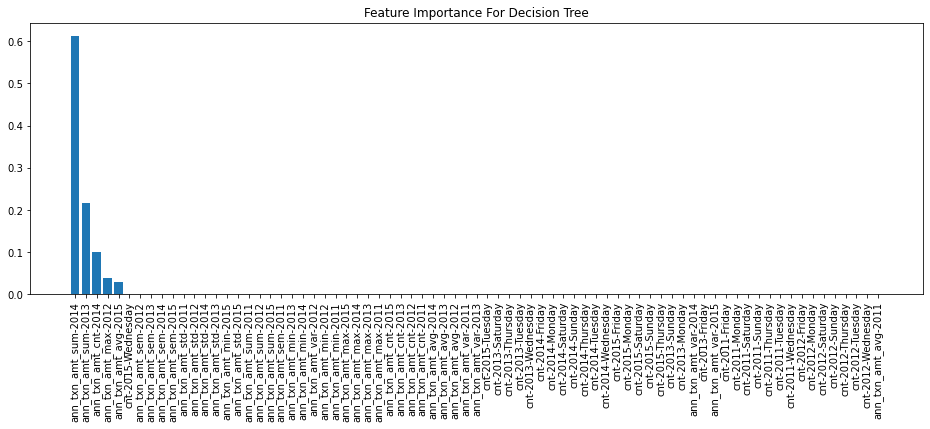

In [26]:
best_dt_model, y_test_pred, y_test_prob, scores_train, scores_test = dt(annual_X_train, annual_X_test, annual_y_train, annual_y_test, annual_X_train, 3)

6. Plot probability distribution for test set.

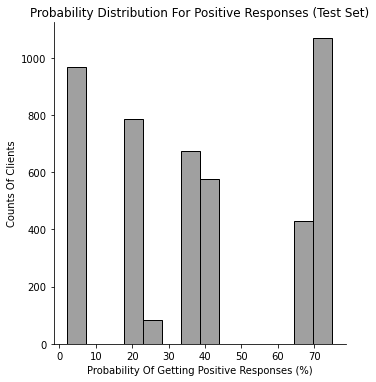

In [27]:
sns.displot(data = y_test_prob[:,1], x = 100 * y_test_prob[:,1], color = 'grey')
plt.title('Probability Distribution For Positive Responses (Test Set)')
plt.xlabel('Probability Of Getting Positive Responses (%)')
plt.ylabel('Counts Of Clients')
plt.show()

7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

Precision: 0.1977363515312916
Recall 0.6585365853658537


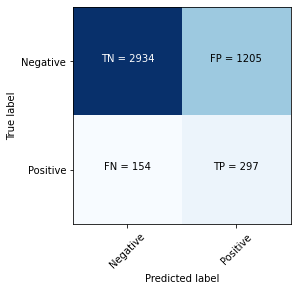

In [28]:
confusion_matrix_test(annual_y_test.values, y_test_pred)

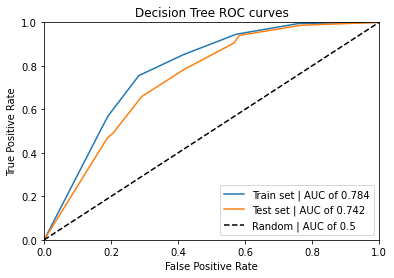

In [29]:
roc(annual_y_train, scores_train, annual_y_test, scores_test, 'Decision Tree')

8. Plot decision boundary for top 2 features.

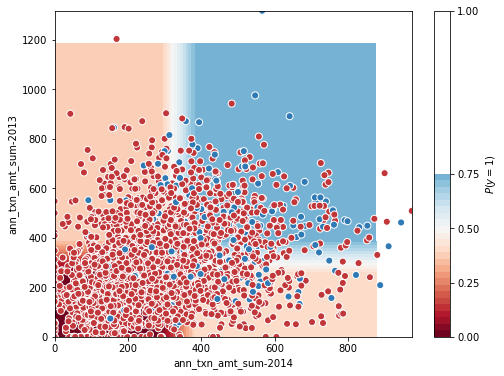

In [31]:
decision_boundary(best_dt_model, 33, 32, annual_X_train.values, annual_X_train, annual_y_train)

## Random Forest - Annual

4. Fit the training dataset and optimize the hyperparameters of the method.

In [32]:
def rf_best(X_train, y_train, X_test, y_test): 
 
    max_depth_range = range(2,20) 
    estimator_max_depth, accuracy_train, accuracy_test, precisions, recalls, f1_train, f1_test, auc_train, auc_test = [],[],[],[],[],[],[],[],[] 
 
    for i in max_depth_range: 
        # Define and fit 
        estimator_max_depth.append(RandomForestClassifier(max_depth = i,class_weight='balanced', random_state=1147)) 
        estimator_max_depth[i-2].fit(X_train, y_train) 
 
        # Score train and test set 
        train_score = estimator_max_depth[i-2].predict_proba(X_train)[:,1] 
        test_score  = estimator_max_depth[i-2].predict_proba(X_test)[:,1] 
 
        # Predict the class of test set 
        y_train_predicted = estimator_max_depth[i-2].predict(X_train) 
        y_test_predicted = estimator_max_depth[i-2].predict(X_test) 
 
        # Calculate training and test accuracy at every iteration and append 
        accuracy_train.append(100*accuracy_score(y_train, y_train_predicted, normalize = True)) 
        accuracy_test.append(100*accuracy_score(y_test, y_test_predicted, normalize = True)) 
 
        # Calculate training and test F1 score at every iteration and append 
        f1_train.append(100 * f1_score(y_train, y_train_predicted)) 
        f1_test.append(100 * f1_score(y_test, y_test_predicted)) 
 
        # Calculate precision and recall 
        precisions.append(precision_score(y_test, y_test_predicted)) 
        recalls.append(recall_score(y_test, y_test_predicted)) 
 
        # ROC Calc trianing and test dataset 
        fpr_train, tpr_train, _ = roc_curve(y_train, train_score) 
        fpr_test, tpr_test, _ = roc_curve(y_test, test_score) 
 
        # Calculate the AUCs 
        auc_train.append(auc(fpr_train, tpr_train)) 
        auc_test.append(auc(fpr_test, tpr_test)) 
 
 
    performance_dictionary = {'ACCURACY_TRAIN': accuracy_train, 
                              'ACCURACY_TEST': accuracy_test,  
                              'F1_TRAIN': f1_train, 
                              'F1_TEST': f1_test, 
                              'PRECISION': precisions, 
                              'RECALL': recalls, 
                              'AUC_TRAIN': auc_train, 
                              'AUC_TEST': auc_test} 
    rf_performance = pd.DataFrame(performance_dictionary) 
    rf_performance.insert(0, 'MAX_DEPTH', value = max_depth_range)  
    
    return rf_performance

In [33]:
annual_rf_performance = rf_best(annual_X_train, annual_y_train, annual_X_test, annual_y_test)
annual_rf_performance

,MAX_DEPTH,ACCURACY_TRAIN,ACCURACY_TEST,F1_TRAIN,F1_TEST,PRECISION,RECALL,AUC_TRAIN,AUC_TEST
0,2,65.693112,64.793028,28.519528,29.555362,0.183939,0.751663,0.798662,0.744882
1,3,69.354839,68.104575,30.464886,30.352046,0.193216,0.707317,0.828058,0.748484
2,4,72.188317,70.130719,32.983193,30.792529,0.199346,0.676275,0.860679,0.746746
3,5,76.721883,73.616558,38.194444,30.522088,0.205882,0.589800,0.901403,0.746880
4,6,82.911944,76.623094,47.027027,28.609448,0.204373,0.476718,0.937654,0.744728
5,7,87.314734,79.084967,56.631893,26.829268,0.204413,0.390244,0.965327,0.743917
6,8,91.761116,83.246187,67.244367,26.411483,0.232323,0.305987,0.985285,0.747458
7,9,93.940715,84.030501,73.624288,23.725286,0.223529,0.252772,0.991858,0.743945
8,10,97.122929,86.514161,85.589520,19.295958,0.234177,0.164080,0.997843,0.742905
9,11,97.689625,87.298475,88.089888,19.363762,0.257353,0.155211,0.998881,0.745005


We can clearly see that the maximum F1_TEST score happens at MAX_DEPTH = 4, with the AUC_TEST in the third place. The reason for choosing MAX_DEPTH = 4 instead of MAX_DEPTH = 5 is becasue the gap between F1_TRAIN & F1_TEST is much higher in 5 than 4.

5. Plot coefficient values or feature importance.

In [34]:
def rf(X_train, X_test, y_train, y_test, X,best_param): 
 
    best_rf_model = RandomForestClassifier(max_depth = best_param, random_state = 1147, class_weight = 'balanced') 
    best_rf_model.fit(X_train, y_train) 

    importances = best_rf_model.feature_importances_ 
    indices = np.argsort(importances)[::-1]
    names = [X.columns[x] for x in indices] 
    print(f'The indices for top 2 features are: {indices[0]}:{names[0]}, {indices[1]}:{names[1]}')
    plt.figure(figsize = (15,9)) 
    plt.title("Feature Importance") 
    plt.bar(range(X.shape[1]), importances[indices]) 
    plt.xticks(range(X.shape[1]), names, rotation = 90) 
    plt.show() 

    y_test_pred = best_rf_model.predict(X_test) 
    y_test_prob = best_rf_model.predict_proba(X_test) 

    train_score = best_rf_model.predict_proba(X_train)[:, 1] 
    test_score = best_rf_model.predict_proba(X_test)[:, 1] 
 
    return best_rf_model, y_test_pred, y_test_prob, train_score, test_score

The indices for top 2 features are: 33:ann_txn_amt_sum-2014, 8:ann_txn_amt_cnt-2014


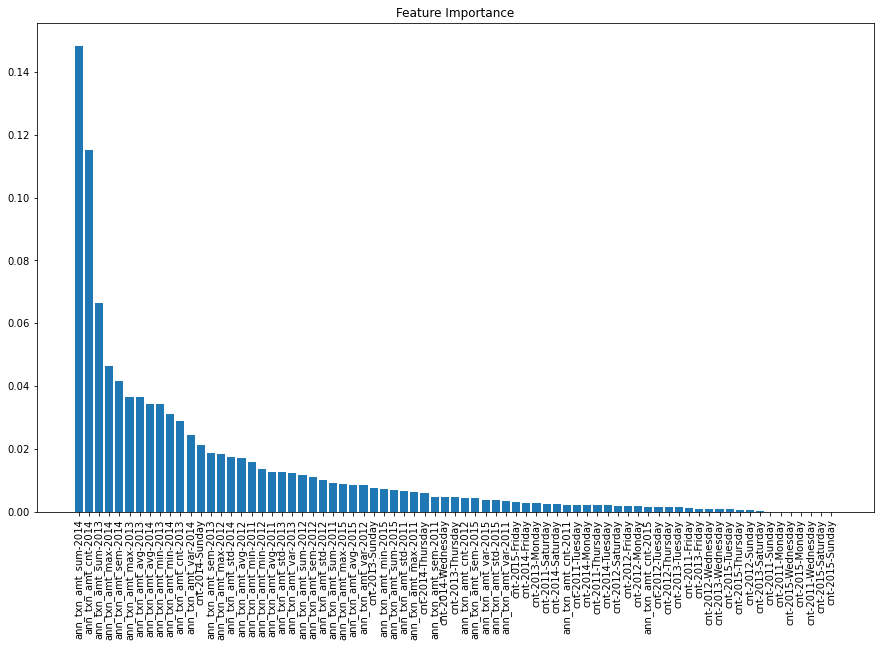

In [35]:
best_rf_model, y_test_pred, y_test_prob, scores_train, scores_test = rf(annual_X_train, annual_X_test, annual_y_train, annual_y_test, annual_X_train, 4)

6. Plot probability distribution for test set.

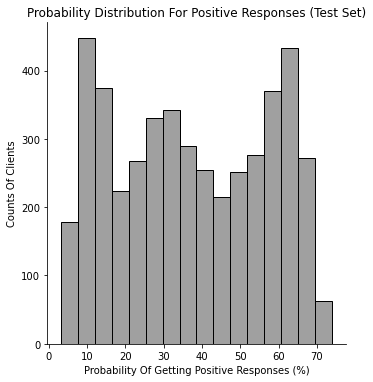

In [36]:
sns.displot(data = y_test_prob[:,1], x = 100*y_test_prob[:,1], color = 'grey')
plt.title('Probability Distribution For Positive Responses (Test Set)')
plt.xlabel('Probability Of Getting Positive Responses (%)')
plt.ylabel('Counts Of Clients')
plt.show()

7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

Precision: 0.19934640522875818
Recall 0.6762749445676275


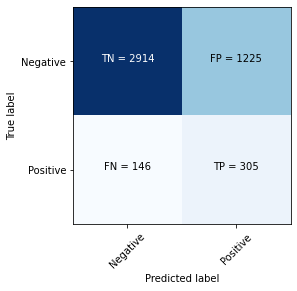

In [37]:
confusion_matrix_test(annual_y_test.values, y_test_pred)

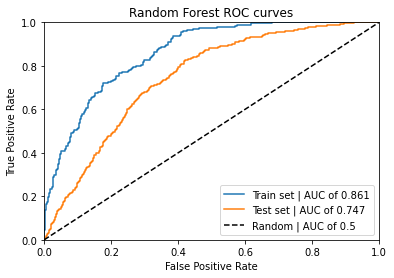

In [38]:
roc(annual_y_train, scores_train, annual_y_test, scores_test, 'Random Forest')

8. Plot decision boundary for top 2 features.

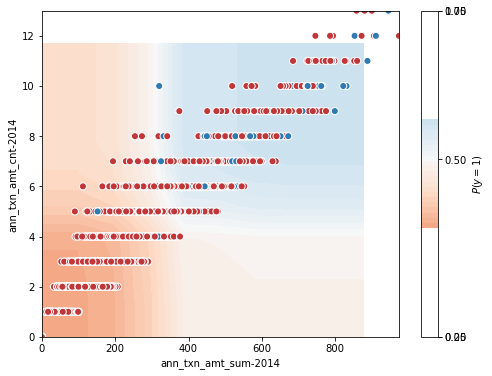

In [41]:
decision_boundary(best_rf_model, 33, 8, annual_X_train.values, annual_X_train, annual_y_train)

## Set up for Monthly Data

In [42]:
# 1.Separate the inputs X and the output y in two data frames.
X_mth = mth_features_outputs.drop(['CLNT_NO', 'response', 'ME_DT'], axis = 1)
y_mth = mth_features_outputs['response']

# 2.Split the data in train and test set.
monthly_X_train, monthly_X_test, monthly_y_train, monthly_y_test = train_test_split(X_mth, y_mth, test_size = 2/3, random_state = 1147)

# 3.Pre-processing
sc = StandardScaler()
monthly_X_train_scaled = sc.fit_transform(monthly_X_train)
monthly_X_test_scaled = sc.transform(monthly_X_test)

## Logistic Regression with L1 regularization - Month

4. Fit the training dataset and optimize the hyperparameters of the method.

In [43]:
import warnings 
warnings.filterwarnings("ignore")
monthly_lr_performance = lr_best(monthly_X_train_scaled, monthly_y_train, monthly_X_test_scaled, monthly_y_test)
monthly_lr_performance

,C,ACCURACY_TRAIN,ACCURACY_TEST,F1_TRAIN,F1_TEST,PRECISION,RECALL,AUC_TRAIN,AUC_TEST
0,0.005,62.449350,62.411045,21.356999,21.364214,0.133011,0.542508,0.627930,0.625614
1,0.025,63.230999,63.122685,21.448805,21.323020,0.133403,0.530933,0.629962,0.627172
2,0.010,63.066881,62.913597,21.476166,21.346050,0.133349,0.534676,0.629644,0.627100
3,0.050,63.353392,63.204744,21.445750,21.299592,0.133342,0.529012,0.630040,0.627170
4,0.250,63.398826,63.272894,21.394719,21.266573,0.133211,0.526992,0.630008,0.627009
5,0.100,63.371009,63.247396,21.422604,21.265903,0.133184,0.527337,0.630137,0.627072
6,0.500,63.400681,63.284948,21.389309,21.259545,0.133181,0.526598,0.629982,0.626988
7,1.000,63.404389,63.279848,21.384750,21.265048,0.133209,0.526845,0.629954,0.626952
8,5.000,63.402535,63.283557,21.374502,21.269870,0.133240,0.526943,0.629934,0.626938
9,10.000,63.401608,63.286802,21.374076,21.272915,0.133261,0.526992,0.629933,0.626940


optimal c = 0.025. The reason for choosing this c is because it has both high F1_TEST score and AUC_TEST scores, the reason for not choosing c = 0.05 is because its ACCURACY_TEST is smaller. 

5. Plot coefficient values or feature importance.

The indices for top 2 features are: 15:amt_mean_12M, 14:amt_sum_12M 


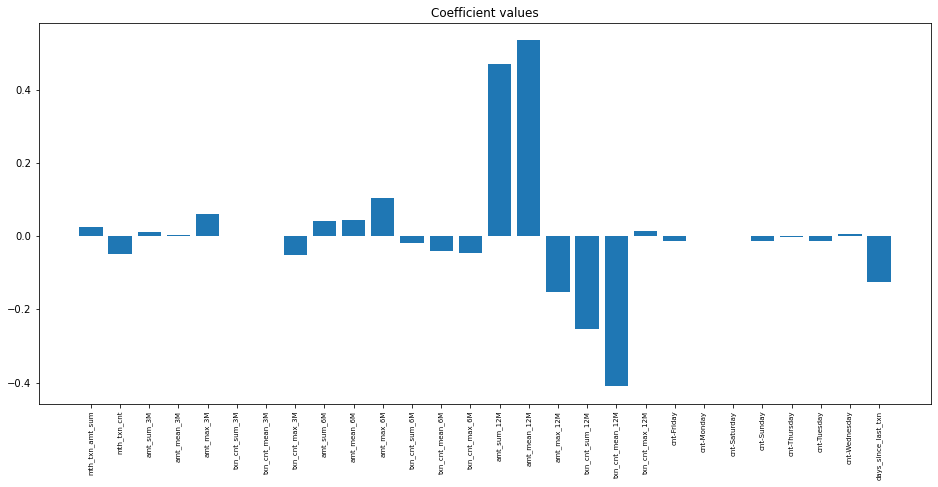

In [49]:
best_lr_model1, y_test_pred, y_test_prob, scores_train, scores_test = logistic(monthly_X_train_scaled, monthly_X_test_scaled, monthly_y_train, monthly_y_test, monthly_X_train, 0.025)

6. Plot probability distribution for test set.

Text(-9.075000000000003, 0.5, 'Counts Of Clients')

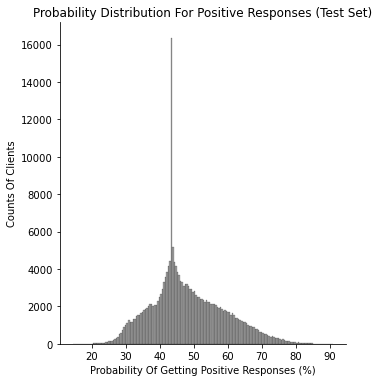

In [45]:
sns.displot(data = y_test_prob[:, 1], x = 100 * y_test_prob[:, 1], color = 'grey')
plt.title('Probability Distribution For Positive Responses (Test Set)')
plt.xlabel('Probability Of Getting Positive Responses (%)')
plt.ylabel('Counts Of Clients')

7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

Precision: 0.13340346534653466
Recall 0.5309329130134962


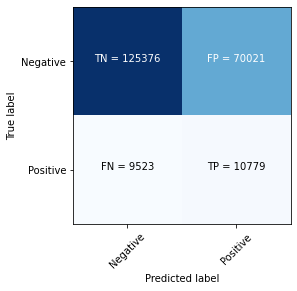

In [46]:
confusion_matrix_test(monthly_y_test.values, y_test_pred)

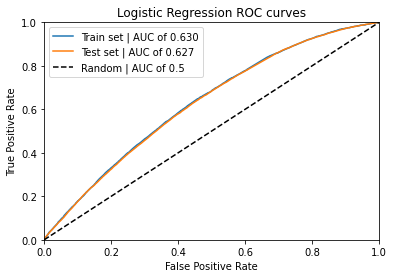

In [47]:
roc(monthly_y_train, scores_train, monthly_y_test, scores_test, 'Logistic Regression')

8.Plot decision boundary for top 2 features.

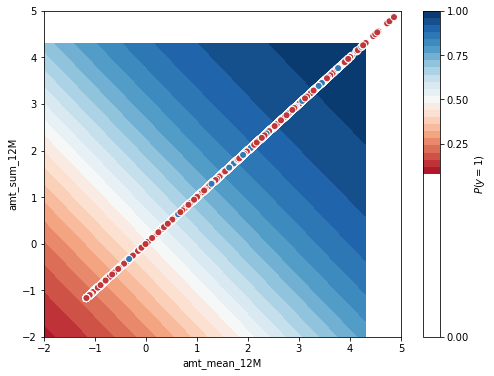

In [50]:
decision_boundary(best_lr_model1, 15, 14, monthly_X_train_scaled, monthly_X_train, monthly_y_train)

## Decision Tree - Month

4. Fit the training dataset and optimize the hyperparameters of the method.

In [51]:
monthly_dt_performance = dt_best(monthly_X_train, monthly_y_train, monthly_X_test, monthly_y_test)
monthly_dt_performance

,MAX_DEPTH,ACCURACY_TRAIN,ACCURACY_TEST,F1_TRAIN,F1_TEST,PRECISION,RECALL,AUC_TRAIN,AUC_TEST
0,2,61.472058,61.424485,21.777108,21.497646,0.132954,0.561176,0.625082,0.620261
1,3,61.634322,61.576085,21.816601,21.519611,0.133206,0.559699,0.635699,0.631349
2,4,58.182273,58.114317,22.055926,21.829603,0.132406,0.621367,0.641477,0.636744
3,5,58.652375,58.562163,22.164040,21.893651,0.133078,0.617033,0.646289,0.637231
4,6,58.093260,57.889930,22.335636,21.933632,0.132849,0.628510,0.652061,0.637487
5,7,55.915215,55.519497,22.452741,21.711600,0.130112,0.655305,0.659198,0.637375
6,8,55.433059,54.817129,22.763574,21.765551,0.130017,0.667767,0.669029,0.637282
7,9,56.909197,55.873231,23.373840,21.661084,0.130033,0.648163,0.682099,0.632549
8,10,55.140984,53.779109,23.705292,21.402330,0.127403,0.668604,0.697937,0.629050


Since Both AUC_TEST and F1_TEST for MAX_DEPTH = 6 achieve the highest score, MAX_DEPTH = 6 can be used as the best hyperparameter for this Decision Tree model. 

5. Plot coefficient values or feature importance.

The indices for top 2 features are: 15:amt_mean_12M, 16:amt_max_12M 


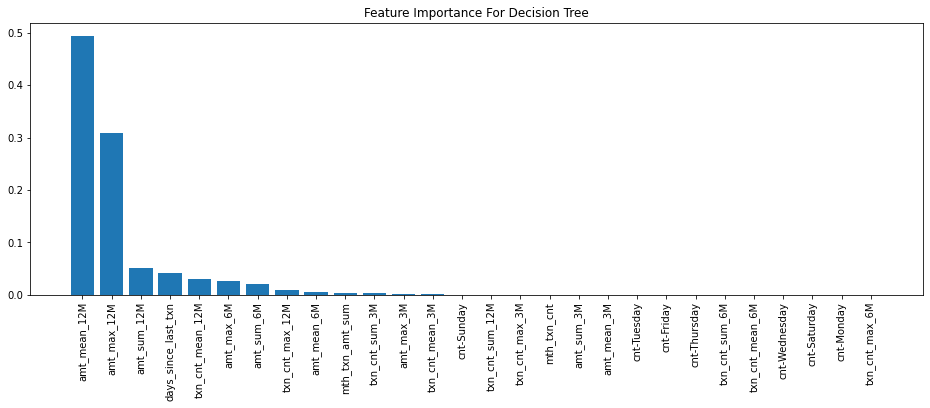

In [52]:
best_dt_model1, y_test_pred, y_test_prob, scores_train, scores_test = dt(monthly_X_train, monthly_X_test, monthly_y_train, monthly_y_test, monthly_X_train, 6)

6. Plot probability distribution for test set.

Text(0, 0.5, 'Counts Of Clients')

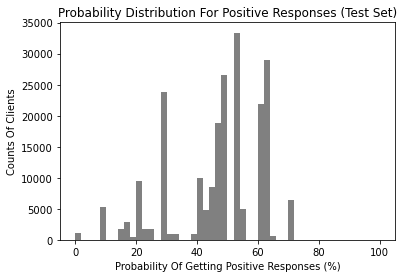

In [53]:
plt.hist(100 * y_test_prob[:,1], bins = 50, color = 'grey')
plt.title('Probability Distribution For Positive Responses (Test Set)')
plt.xlabel('Probability Of Getting Positive Responses (%)')
plt.ylabel('Counts Of Clients')

7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

Precision: 0.1328488583951941
Recall 0.6285095064525662


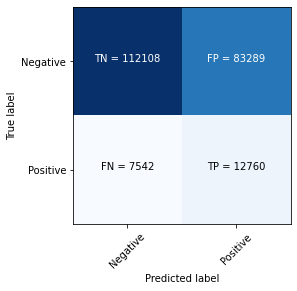

In [54]:
confusion_matrix_test(monthly_y_test.values, y_test_pred)

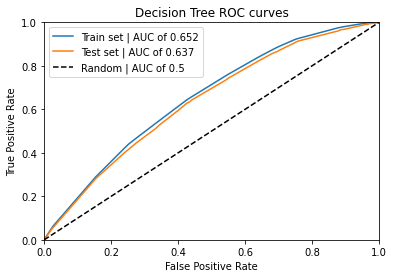

In [55]:
roc(monthly_y_train, scores_train, monthly_y_test, scores_test, 'Decision Tree')

8. Plot decision boundary for top 2 features.

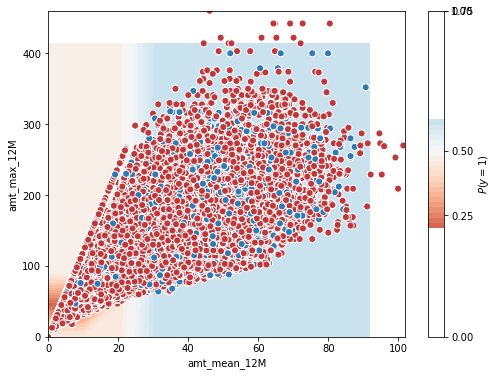

In [56]:
decision_boundary(best_dt_model1, 15, 16, monthly_X_train.values, monthly_X_train, monthly_y_train)

## Random Forest - Month

4. Fit the training dataset and optimize the hyperparameters of the method

In [57]:
monthly_rf_performance = rf_best(monthly_X_train, monthly_y_train, monthly_X_test, monthly_y_test)
monthly_rf_performance

,MAX_DEPTH,ACCURACY_TRAIN,ACCURACY_TEST,F1_TRAIN,F1_TEST,PRECISION,RECALL,AUC_TRAIN,AUC_TEST
0,2,60.219381,60.171350,21.848188,21.626405,0.132712,0.583834,0.636381,0.631647
1,3,59.811403,59.741121,21.931231,21.736544,0.133022,0.593981,0.641953,0.636168
2,4,59.011210,58.852382,22.095728,21.825869,0.132893,0.610285,0.646858,0.639494
3,5,57.493347,57.189417,22.301317,21.934600,0.132396,0.639001,0.653301,0.641708
4,6,57.761314,57.416122,22.737449,22.033596,0.133106,0.639297,0.663171,0.644220
5,7,59.041808,58.317841,23.455614,22.099572,0.134084,0.628165,0.675895,0.645769
6,8,60.619941,59.385069,24.510762,22.176424,0.135280,0.614816,0.692251,0.647564
7,9,62.966741,61.188972,25.891565,22.255036,0.137130,0.590188,0.713857,0.647778
8,10,65.807750,63.353099,27.696953,22.346874,0.139570,0.560240,0.739534,0.649050
9,11,68.917653,65.786119,30.095508,22.407503,0.142443,0.524874,0.770779,0.647978


We can clearly see that the maximum F1_TEST score happens at MAX_DEPTH = 12, with the AUC_TEST in the third place. The reason for choosing MAX_DEPTH = 12 instead of MAX_DEPTH = 5 is becasue the gap between F1_TRAIN & F1_TEST is much higher in 5 than 4.

5. Plot coefficient values or feature importance.

The indices for top 2 features are: 14:amt_sum_12M, 15:amt_mean_12M


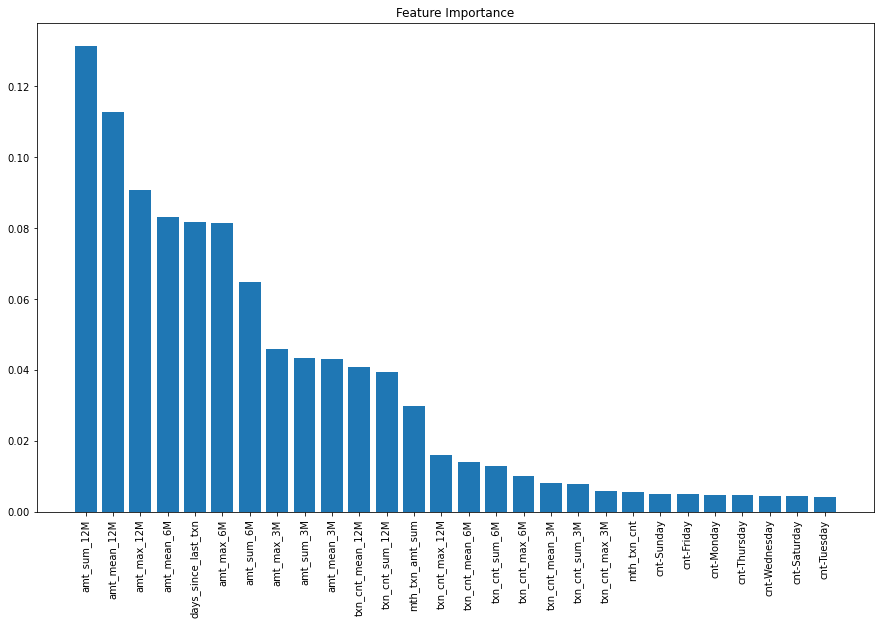

In [58]:
best_rf_model1, y_test_pred, y_test_prob, scores_train, scores_test = rf(monthly_X_train, monthly_X_test, monthly_y_train, monthly_y_test, monthly_X_train, 12)

6. Plot probability distribution for test set.

Text(0, 0.5, 'Counts Of Clients')

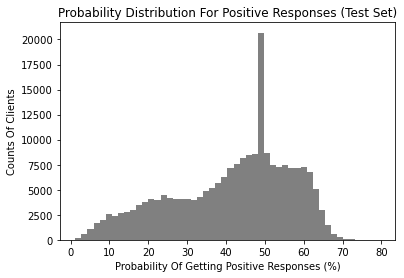

In [59]:
plt.hist(100 * y_test_prob[:,1], bins = 50, color = 'grey')
plt.title('Probability Distribution For Positive Responses (Test Set)')
plt.xlabel('Probability Of Getting Positive Responses (%)')
plt.ylabel('Counts Of Clients')

7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

Precision: 0.14503372030355557
Recall 0.49044429120283717


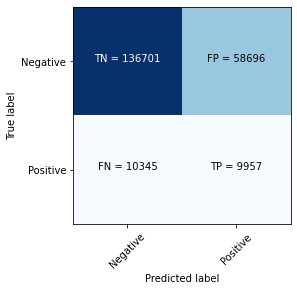

In [60]:
confusion_matrix_test(monthly_y_test.values, y_test_pred)

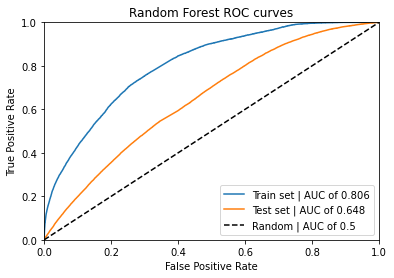

In [61]:
roc(monthly_y_train, scores_train, monthly_y_test, scores_test, 'Random Forest')

8. Plot decision boundary for top 2 features.

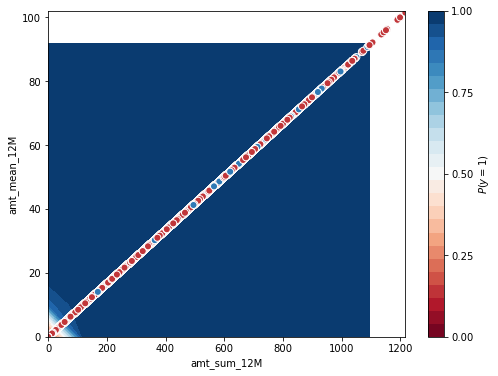

In [62]:
decision_boundary(best_model, 14, 15, monthly_X_train.values, monthly_X_train, monthly_y_train)

## 1.3 Comparsion of Methods
Compare the two feature engineering (annual and monthly) and the three modeling ap-
proaches (L1 log-reg, tree, forests) in terms of the outcomes of steps 5-8. Which combina-
tion of feature engineering and modeling approach do you select as the best to deploy in a
production environment and why? Tabularize your findings in steps 5-8 to summarize the
results and support your decision (how to organize information with tables in Markdown).


| Annual | L1 Logistic| Decision Tree | Random Forest || |
| :---------: | :---------: | :---------: | :---------: | :---------: | :---------: | 
| Precision (Test) | 0.202 | 0.198 | 0.199 |
| Recall (Test) | 0.685 | 0.659 | 0.676 |
| Train Accuracy |  0.715 |  0.721 | 0.722 |
| Test Accuracy  | 0.703  | 0.704 | 0.701 |
| Train F1  | 0.310  | 0.316 |  0.330|
| Test F1  | 0.312  | 0.304 |  0.308|
| Train AUC  | 0.808  | 0.861 |  0.861|
| Test AUC  | 0.765  | 0.747 |  0.747|
| Number of TP  | 309  | 297 |  305|
| Number of FP  | 1022  | 1205 |  1225|
| Top 2 Features  | 32:ann_txn_amt_sum-2013; 8:ann_txn_ant_cnt-2014| 33:ann_txn_amt_sum-2014; 32:ann_txn_amt_sum-2013 |33:ann_txn_amt_sum-2014; 8:ann_txn_ant_cnt-2014|

| Month | L1 Logistic| Decision Tree | Random Forest || |
| :---------: | :---------: | :---------: | :---------: | :---------: | :---------: | 
| Precision (Test) | 0.133 | 0.133 | 0.145 |
| Recall (Test) | 0.531 | 0.629 | 0.490 |
| Train Accuracy |  0.632 |  0.581 | 0.720 |
| Test Accuracy  | 0.631  | 0.579 | 0.680 |
| Train F1  | 0.214  | 0.223 |  0.330|
| Test F1  | 0.213  | 0.219 |  0.224|
| Train AUC  | 0.630  | 0.652 |  0.806|
| Test AUC  | 0.627  | 0.637 |  0.648|
| Number of TP  | 10779  | 12760 |  9957|
| Number of FP  | 70021  | 83289 |  58696|
| Top 2 Features  | 15:amt_mean_12M; 14:amt_sum_12M | 15:amt_mean_12M; 16:amt_max_12M |14:amt_sum_12M; 15:amt_mean_12M |

### Discussion: Compare Two Feature Engineering Methods

Metric: All metrics for annual features have higher scores than monthly features. One of the possible reasons is that monthly dataset has more records but fewer features so that the models are not able to gather enough information and fit well. While we can try to design more features for monthly data to improve models’ metrics scores. 

Top 2 features: It is interesting that all models’ top 2 features are targeting long-term. These are annual sum/count & 12 months (can be considered as annual?) mean/sum/count/max of transactions. The benefit is that models will not be affected by outliers in the short-term. 

Confusion Matrix: Taking ratios of the number of False Positives over the number of True Positives, we can find out that the ratio of annual data is smaller than the ratio of monthly data: (1/3 ~ 1/4) < (1/6 ~ 1/7). This implies that there are more true predictions in annual data than in monthly data. 

### Discussion: Compare Three Models

Metric: For annual feature, L1 Logistic Regression has the best performance metric because it has the least number of False Positive and the highest score of precision. While for monthly feature, Random Forest performs best. Random Forest uses information from all features from the dataset and can aggregate multiple trees and choose the majority votes as results. 

Confusion Matrix: For annual feature, L1 Logistic Regression has the highest Recall score, True Positive and Test Accuracy. While for monthly feature, even though it still has the highest Recall score and True Positive, Random Forest has the highest Test Accuracy. 

### The Best Combination: Annual Feature Engineering with L1 Logistic Regression

The goal is to engage more with clients with positive responses. We focus on the Recall score of all models because we want as many clients who show interests as we can classify them correctly. According to the above analysis, the annual feature can better help us know the big picture of the profile of our clients, neglecting the influence of monthly feature fluctuations. And L1 Logistic Regression feature has the best precision, recall, accuracy and AUC scores. Thus, this model is the most appropriate model. 